Analyse de données du lab 4 de TPA. Électrolyse de l'eau.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit, root_scalar

plt.rcParams.update({
    "axes.labelsize": 24,    # Axis labels
    "xtick.labelsize": 24,   # X-axis tick labels
    "ytick.labelsize": 24,   # Y-axis tick labels
    "legend.fontsize": 20    # Legend
})

In [2]:
# Données brutes extraites du fichier CSV

# Noms des configurations d'électrodes testées
electrodes = [
    'Laiton',
    'Cuivre- Carbon+ V2',
    'Cuivre- Carbon+',
    'Aluminium',
    'Stainless',
    'Stainless (concentration++)',
    'Carbone',
    'Titane',
    'Titane- carbone+'
]

# Paramètres expérimentaux
concentration_NaHCO3 = 0.0181  # g/g (identique pour toutes les configurations)

# Données mesurées pour chaque configuration
# Résistances [ohms]
resistances = [19.23, 19.23, 17.86, 18.35, 15.87, 6.67, 16.67, 2207.14, 20.02]

# Courant stable [A]
courant_stable = [0.52, 0.52, 0.56, 0.545, 0.63, 1.5, 0.6, 0.014, 0.5]

# Tension stable [V]
tension_stable = [10, 10, 10, 10, 10, 10, 10, 30.9, 10.01]

# Puissance [W]
puissance = [5.2, 5.2, 5.6, 5.45, 6.3, 15, 6, 0.4326, 5.005]

# Énergie totale [J]
energie = [3078.4, 2860, np.nan, 2828.55, 2520, 1815, 2340, 545.076, 3578.575]

# Temps d'expérience [s]
temps = [592, 550, np.nan, 519, 400, 121, 390, 1260, 715]

# Volumes pré-hydrolyse [ml]
vol_pre_plus = [16, 34.5, 68, 50.5, 12, 30, 9, 27, 30]  # Éprouvette (+)
vol_pre_moins = [57, 15, 5, 59, 26, 70, 11, 45, 50]  # Éprouvette (-)

# Volumes post-hydrolyse [ml]
vol_post_plus = [33, 49.5, 88, 66.5, 20, 44, 27, 27.5, 53]  # Éprouvette (+)
vol_post_moins = [99, 55, 54, 100, 60, 100, 43, 45.5, 97]  # Éprouvette (-)

# Longueurs exposées [cm]
longueur_plus = [4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 3.9, 4.3]  # Éprouvette (+)
longueur_moins = [2.6, 2.5, 2.6, 3.4, 3.6, 3.6, 4.1, 3.8, 3.8]  # Éprouvette (-)

# Calcul des volumes produits [ml]
volume_H2 = [post - pre for post, pre in zip(vol_post_moins, vol_pre_moins)]  # H₂ produit à la cathode (-)
volume_O2 = [post - pre for post, pre in zip(vol_post_plus, vol_pre_plus)]  # O₂ produit à l'anode (+)

# Taux volumétriques [ml/s]
taux_vol_H2 = [vol/t if not np.isnan(t) else np.nan for vol, t in zip(volume_H2, temps)]
taux_vol_O2 = [vol/t if not np.isnan(t) else np.nan for vol, t in zip(volume_O2, temps)]

# Taux énergétique [ml/J]
taux_energetique = [vol_h2/e if not np.isnan(e) else np.nan 
                    for vol_h2, e in zip(volume_H2, energie)]

print("Données importées avec succès!")
print(f"Nombre de configurations testées: {len(electrodes)}")
print(f"\nVolumes H₂ produits: {volume_H2} ml")
print(f"Volumes O₂ produits: {volume_O2} ml")

Données importées avec succès!
Nombre de configurations testées: 9

Volumes H₂ produits: [42, 40, 49, 41, 34, 30, 32, 0.5, 47] ml
Volumes O₂ produits: [17, 15.0, 20, 16.0, 8, 14, 18, 0.5, 23] ml


## Création d'un DataFrame pour faciliter l'analyse

Organisons les données dans un tableau structuré pour une analyse plus facile.

In [3]:
import pandas as pd

# Créer un DataFrame avec toutes les données
data = {
    'Électrodes': electrodes,
    'Résistance [Ω]': resistances,
    'Courant [A]': courant_stable,
    'Tension [V]': tension_stable,
    'Puissance [W]': puissance,
    'Énergie [J]': energie,
    'Temps [s]': temps,
    'Volume H₂ [ml]': volume_H2,
    'Volume O₂ [ml]': volume_O2,
    'Taux H₂ [ml/s]': taux_vol_H2,
    'Taux O₂ [ml/s]': taux_vol_O2,
    'Efficacité [ml H₂/J]': taux_energetique,
    'Longueur anode [cm]': longueur_plus,
    'Longueur cathode [cm]': longueur_moins
}

df = pd.DataFrame(data)

# Afficher le tableau
print("="*100)
print("DONNÉES EXPÉRIMENTALES - ÉLECTROLYSE DE L'EAU")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# Statistiques de base
print("\n" + "="*100)
print("STATISTIQUES DESCRIPTIVES")
print("="*100)
print(df.describe())
print("="*100)

DONNÉES EXPÉRIMENTALES - ÉLECTROLYSE DE L'EAU
                 Électrodes  Résistance [Ω]  Courant [A]  Tension [V]  Puissance [W]  Énergie [J]  Temps [s]  Volume H₂ [ml]  Volume O₂ [ml]  Taux H₂ [ml/s]  Taux O₂ [ml/s]  Efficacité [ml H₂/J]  Longueur anode [cm]  Longueur cathode [cm]
                     Laiton           19.23        0.520        10.00         5.2000     3078.400      592.0            42.0            17.0        0.070946        0.028716              0.013643                  4.4                    2.6
         Cuivre- Carbon+ V2           19.23        0.520        10.00         5.2000     2860.000      550.0            40.0            15.0        0.072727        0.027273              0.013986                  4.4                    2.5
            Cuivre- Carbon+           17.86        0.560        10.00         5.6000          NaN        NaN            49.0            20.0             NaN             NaN                   NaN                  4.4                    2.

## Calculs et analyses supplémentaires

Calculons des métriques supplémentaires pour analyser les performances de chaque configuration d'électrodes.

In [4]:
# Calculs supplémentaires

# Ratio volumétrique H₂/O₂ (théoriquement devrait être 2:1)
df['Ratio H₂/O₂'] = df['Volume H₂ [ml]'] / df['Volume O₂ [ml]']

# Densité de courant [A/cm²] pour chaque électrode
df['Densité courant anode [A/cm²]'] = df['Courant [A]'] / df['Longueur anode [cm]']
df['Densité courant cathode [A/cm²]'] = df['Courant [A]'] / df['Longueur cathode [cm]']

# Efficacité énergétique [ml/Wh] (conversion de J en Wh: 1 Wh = 3600 J)
df['Efficacité H₂ [ml/Wh]'] = (df['Volume H₂ [ml]'] / df['Énergie [J]']) * 3600

# Production spécifique par unité de temps et de puissance
df['Production spécifique [ml/(W·s)]'] = df['Volume H₂ [ml]'] / (df['Puissance [W]'] * df['Temps [s]'])

# Vérification de la loi d'Ohm: V = R × I
df['Tension calculée V=R×I [V]'] = df['Résistance [Ω]'] * df['Courant [A]']
df['Écart tension [%]'] = abs(df['Tension calculée V=R×I [V]'] - df['Tension [V]']) / df['Tension [V]'] * 100

print("="*100)
print("MÉTRIQUES CALCULÉES")
print("="*100)
print(df[['Électrodes', 'Ratio H₂/O₂', 'Efficacité H₂ [ml/Wh]', 
          'Densité courant cathode [A/cm²]', 'Écart tension [%]']].to_string(index=False))
print("="*100)

MÉTRIQUES CALCULÉES
                 Électrodes  Ratio H₂/O₂  Efficacité H₂ [ml/Wh]  Densité courant cathode [A/cm²]  Écart tension [%]
                     Laiton     2.470588              49.116424                         0.200000           0.004000
         Cuivre- Carbon+ V2     2.666667              50.349650                         0.208000           0.004000
            Cuivre- Carbon+     2.450000                    NaN                         0.215385           0.016000
                  Aluminium     2.562500              52.182214                         0.160294           0.007500
                  Stainless     4.250000              48.571429                         0.175000           0.019000
Stainless (concentration++)     2.142857              59.504132                         0.416667           0.050000
                    Carbone     1.777778              49.230769                         0.146341           0.020000
                     Titane     1.000000            

## Visualisations graphiques

Créons des graphiques pour comparer les performances des différentes configurations d'électrodes.

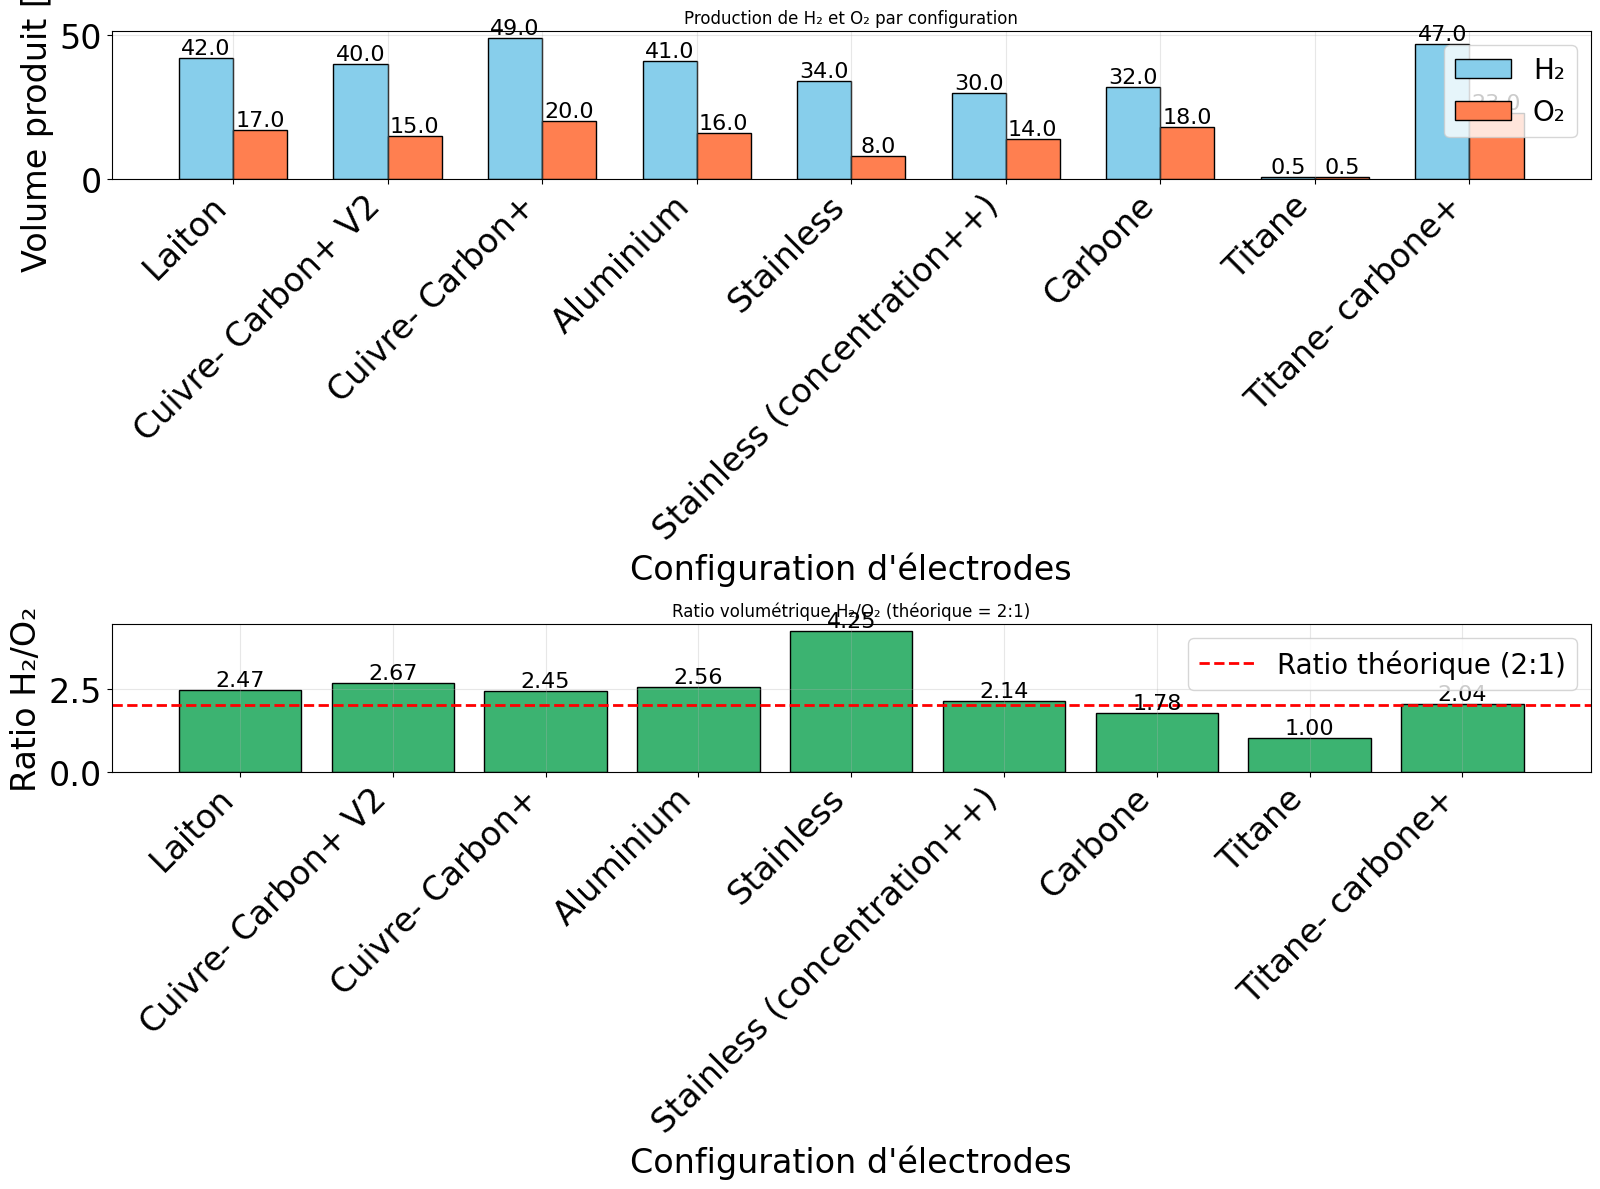

In [5]:
# Graphique 1: Production de H₂ et O₂ pour chaque configuration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Filtrer les données valides (sans NaN)
df_valid = df[df['Volume H₂ [ml]'].notna()]

x = np.arange(len(df_valid))
width = 0.35

# Subplot 1: Volumes produits
bars1 = ax1.bar(x - width/2, df_valid['Volume H₂ [ml]'], width, label='H₂', color='skyblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, df_valid['Volume O₂ [ml]'], width, label='O₂', color='coral', edgecolor='black')

ax1.set_xlabel('Configuration d\'électrodes')
ax1.set_ylabel('Volume produit [ml]')
ax1.set_title('Production de H₂ et O₂ par configuration')
ax1.set_xticks(x)
ax1.set_xticklabels(df_valid['Électrodes'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=16)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=16)

# Subplot 2: Ratio H₂/O₂
bars3 = ax2.bar(x, df_valid['Ratio H₂/O₂'], color='mediumseagreen', edgecolor='black')
ax2.axhline(y=2, color='red', linestyle='--', linewidth=2, label='Ratio théorique (2:1)')

ax2.set_xlabel('Configuration d\'électrodes')
ax2.set_ylabel('Ratio H₂/O₂')
ax2.set_title('Ratio volumétrique H₂/O₂ (théorique = 2:1)')
ax2.set_xticks(x)
ax2.set_xticklabels(df_valid['Électrodes'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.show()

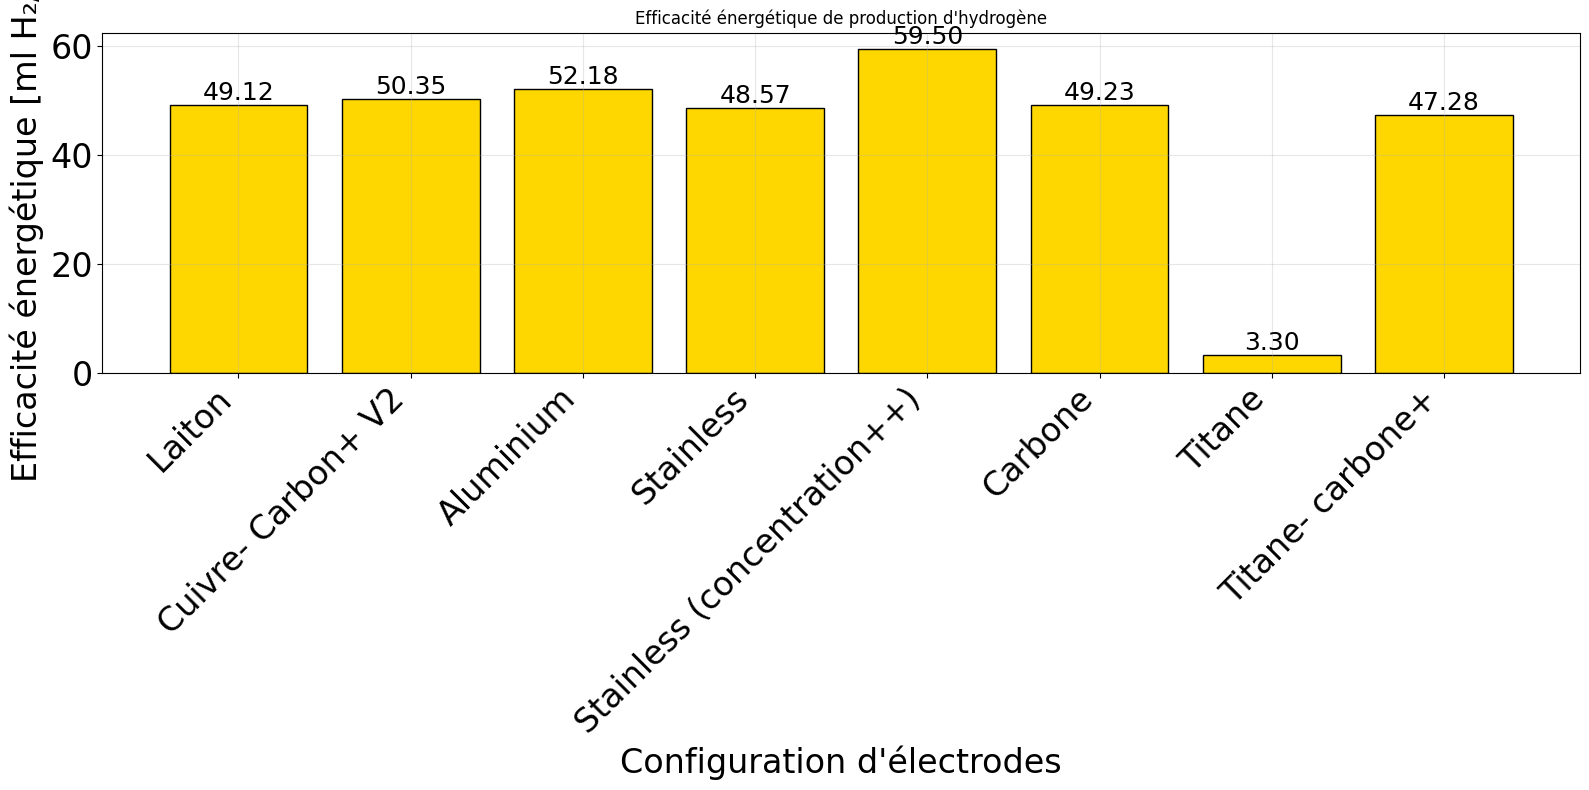


Configuration la plus efficace énergétiquement:
  Stainless (concentration++)
  Efficacité: 59.504 ml H₂/Wh


In [6]:
# Graphique 2: Efficacité énergétique
fig, ax = plt.subplots(figsize=(16, 8))

df_valid = df[df['Efficacité H₂ [ml/Wh]'].notna()]
x = np.arange(len(df_valid))

bars = ax.bar(x, df_valid['Efficacité H₂ [ml/Wh]'], color='gold', edgecolor='black')

ax.set_xlabel('Configuration d\'électrodes')
ax.set_ylabel('Efficacité énergétique [ml H₂/Wh]')
ax.set_title('Efficacité énergétique de production d\'hydrogène')
ax.set_xticks(x)
ax.set_xticklabels(df_valid['Électrodes'], rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=18)

plt.tight_layout()
plt.show()

# Identifier la meilleure configuration
best_idx = df_valid['Efficacité H₂ [ml/Wh]'].idxmax()
print(f"\n{'='*80}")
print(f"Configuration la plus efficace énergétiquement:")
print(f"  {df_valid.loc[best_idx, 'Électrodes']}")
print(f"  Efficacité: {df_valid.loc[best_idx, 'Efficacité H₂ [ml/Wh]']:.3f} ml H₂/Wh")
print(f"{'='*80}")

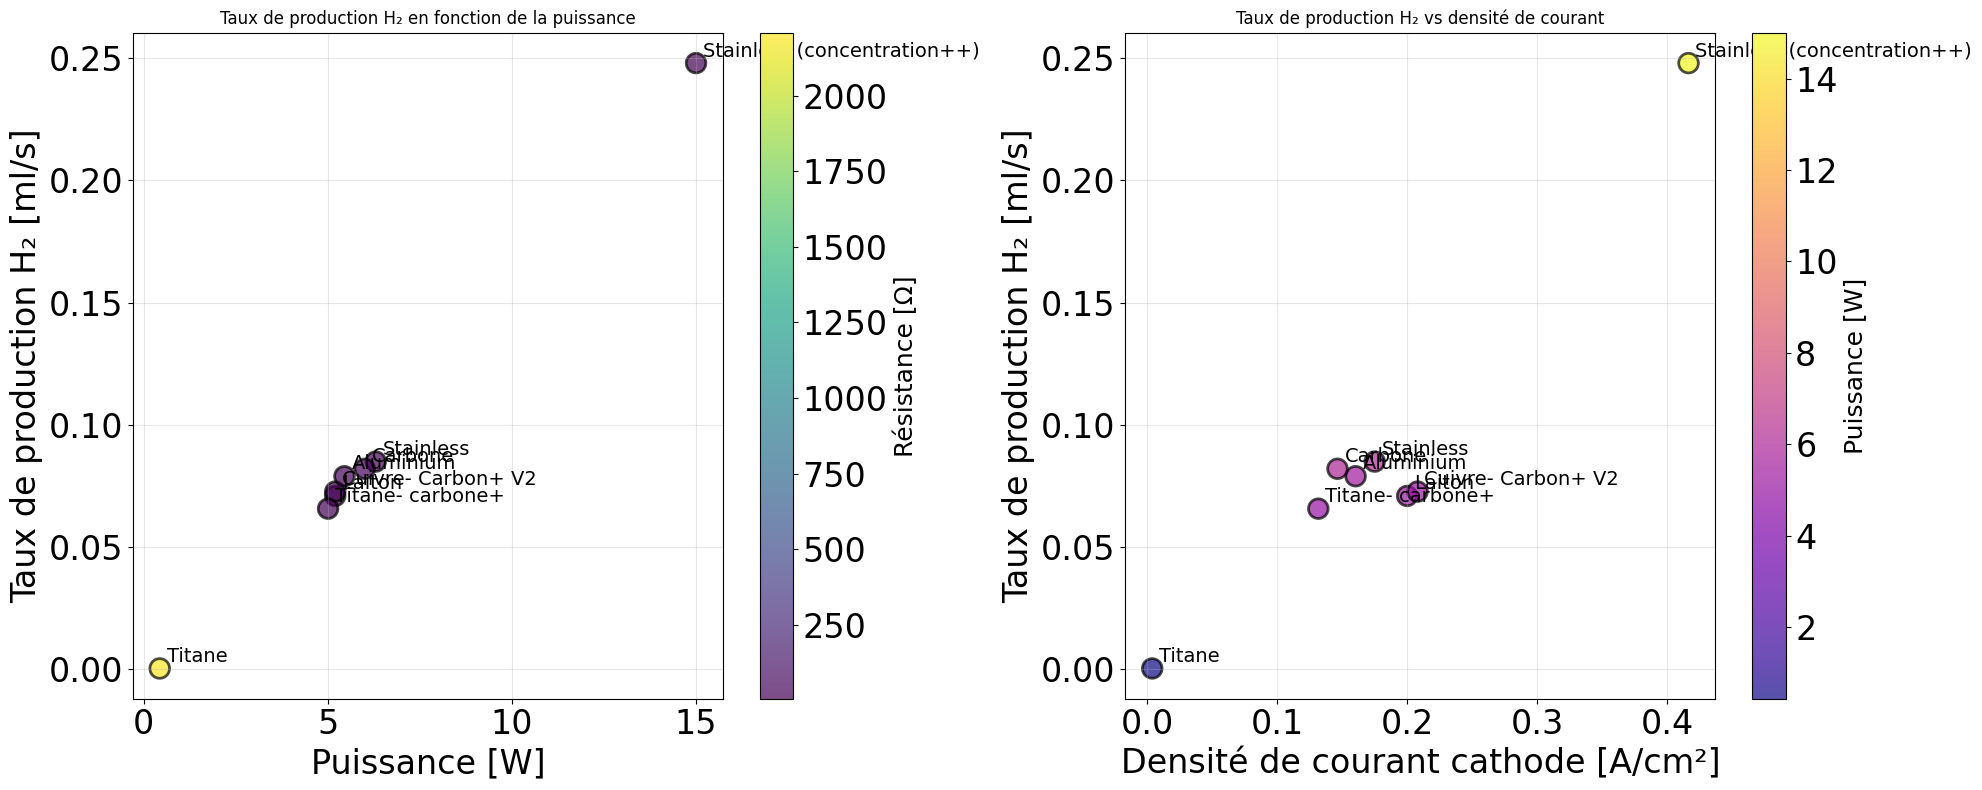

In [7]:
# Graphique 3: Taux de production vs Puissance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

df_valid = df[df['Taux H₂ [ml/s]'].notna()]

# Subplot 1: Taux de production H₂ vs Puissance
scatter1 = ax1.scatter(df_valid['Puissance [W]'], df_valid['Taux H₂ [ml/s]'], 
                       s=200, c=df_valid['Résistance [Ω]'], cmap='viridis', 
                       edgecolor='black', linewidth=2, alpha=0.7)

# Ajouter les étiquettes
for idx, row in df_valid.iterrows():
    ax1.annotate(row['Électrodes'], 
                (row['Puissance [W]'], row['Taux H₂ [ml/s]']),
                xytext=(5, 5), textcoords='offset points', fontsize=14)

ax1.set_xlabel('Puissance [W]')
ax1.set_ylabel('Taux de production H₂ [ml/s]')
ax1.set_title('Taux de production H₂ en fonction de la puissance')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Résistance [Ω]', fontsize=18)

# Subplot 2: Densité de courant vs Taux de production
scatter2 = ax2.scatter(df_valid['Densité courant cathode [A/cm²]'], 
                       df_valid['Taux H₂ [ml/s]'], 
                       s=200, c=df_valid['Puissance [W]'], cmap='plasma', 
                       edgecolor='black', linewidth=2, alpha=0.7)

# Ajouter les étiquettes
for idx, row in df_valid.iterrows():
    ax2.annotate(row['Électrodes'], 
                (row['Densité courant cathode [A/cm²]'], row['Taux H₂ [ml/s]']),
                xytext=(5, 5), textcoords='offset points', fontsize=14)

ax2.set_xlabel('Densité de courant cathode [A/cm²]')
ax2.set_ylabel('Taux de production H₂ [ml/s]')
ax2.set_title('Taux de production H₂ vs densité de courant')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Puissance [W]', fontsize=18)

plt.tight_layout()
plt.show()

## Analyse comparative et conclusions

Comparons les performances globales de chaque configuration.

In [8]:
# Tableau récapitulatif des meilleures configurations
print("="*100)
print("CLASSEMENT DES CONFIGURATIONS")
print("="*100)

df_valid = df[df['Efficacité H₂ [ml/Wh]'].notna()].copy()

# Classement par efficacité énergétique
print("\n1. PAR EFFICACITÉ ÉNERGÉTIQUE (ml H₂/Wh):")
print("-"*100)
df_sorted = df_valid.sort_values('Efficacité H₂ [ml/Wh]', ascending=False)
for i, (idx, row) in enumerate(df_sorted.iterrows(), 1):
    print(f"  {i}. {row['Électrodes']:<35} {row['Efficacité H₂ [ml/Wh]']:>10.3f} ml H₂/Wh")

# Classement par taux de production
print("\n2. PAR TAUX DE PRODUCTION (ml H₂/s):")
print("-"*100)
df_sorted = df_valid.sort_values('Taux H₂ [ml/s]', ascending=False)
for i, (idx, row) in enumerate(df_sorted.iterrows(), 1):
    print(f"  {i}. {row['Électrodes']:<35} {row['Taux H₂ [ml/s]']:>10.5f} ml/s")

# Classement par production totale
print("\n3. PAR PRODUCTION TOTALE (ml H₂):")
print("-"*100)
df_sorted = df_valid.sort_values('Volume H₂ [ml]', ascending=False)
for i, (idx, row) in enumerate(df_sorted.iterrows(), 1):
    print(f"  {i}. {row['Électrodes']:<35} {row['Volume H₂ [ml]']:>10.1f} ml")

# Analyse du ratio H₂/O₂
print("\n4. CONFORMITÉ AU RATIO THÉORIQUE H₂/O₂ = 2:1:")
print("-"*100)
df_valid['Écart ratio [%]'] = abs(df_valid['Ratio H₂/O₂'] - 2) / 2 * 100
df_sorted = df_valid.sort_values('Écart ratio [%]', ascending=True)
for i, (idx, row) in enumerate(df_sorted.iterrows(), 1):
    print(f"  {i}. {row['Électrodes']:<35} Ratio: {row['Ratio H₂/O₂']:>6.3f}  Écart: {row['Écart ratio [%]']:>6.2f}%")

print("\n" + "="*100)

CLASSEMENT DES CONFIGURATIONS

1. PAR EFFICACITÉ ÉNERGÉTIQUE (ml H₂/Wh):
----------------------------------------------------------------------------------------------------
  1. Stainless (concentration++)             59.504 ml H₂/Wh
  2. Aluminium                               52.182 ml H₂/Wh
  3. Cuivre- Carbon+ V2                      50.350 ml H₂/Wh
  4. Carbone                                 49.231 ml H₂/Wh
  5. Laiton                                  49.116 ml H₂/Wh
  6. Stainless                               48.571 ml H₂/Wh
  7. Titane- carbone+                        47.281 ml H₂/Wh
  8. Titane                                   3.302 ml H₂/Wh

2. PAR TAUX DE PRODUCTION (ml H₂/s):
----------------------------------------------------------------------------------------------------
  1. Stainless (concentration++)            0.24793 ml/s
  2. Stainless                              0.08500 ml/s
  3. Carbone                                0.08205 ml/s
  4. Aluminium              

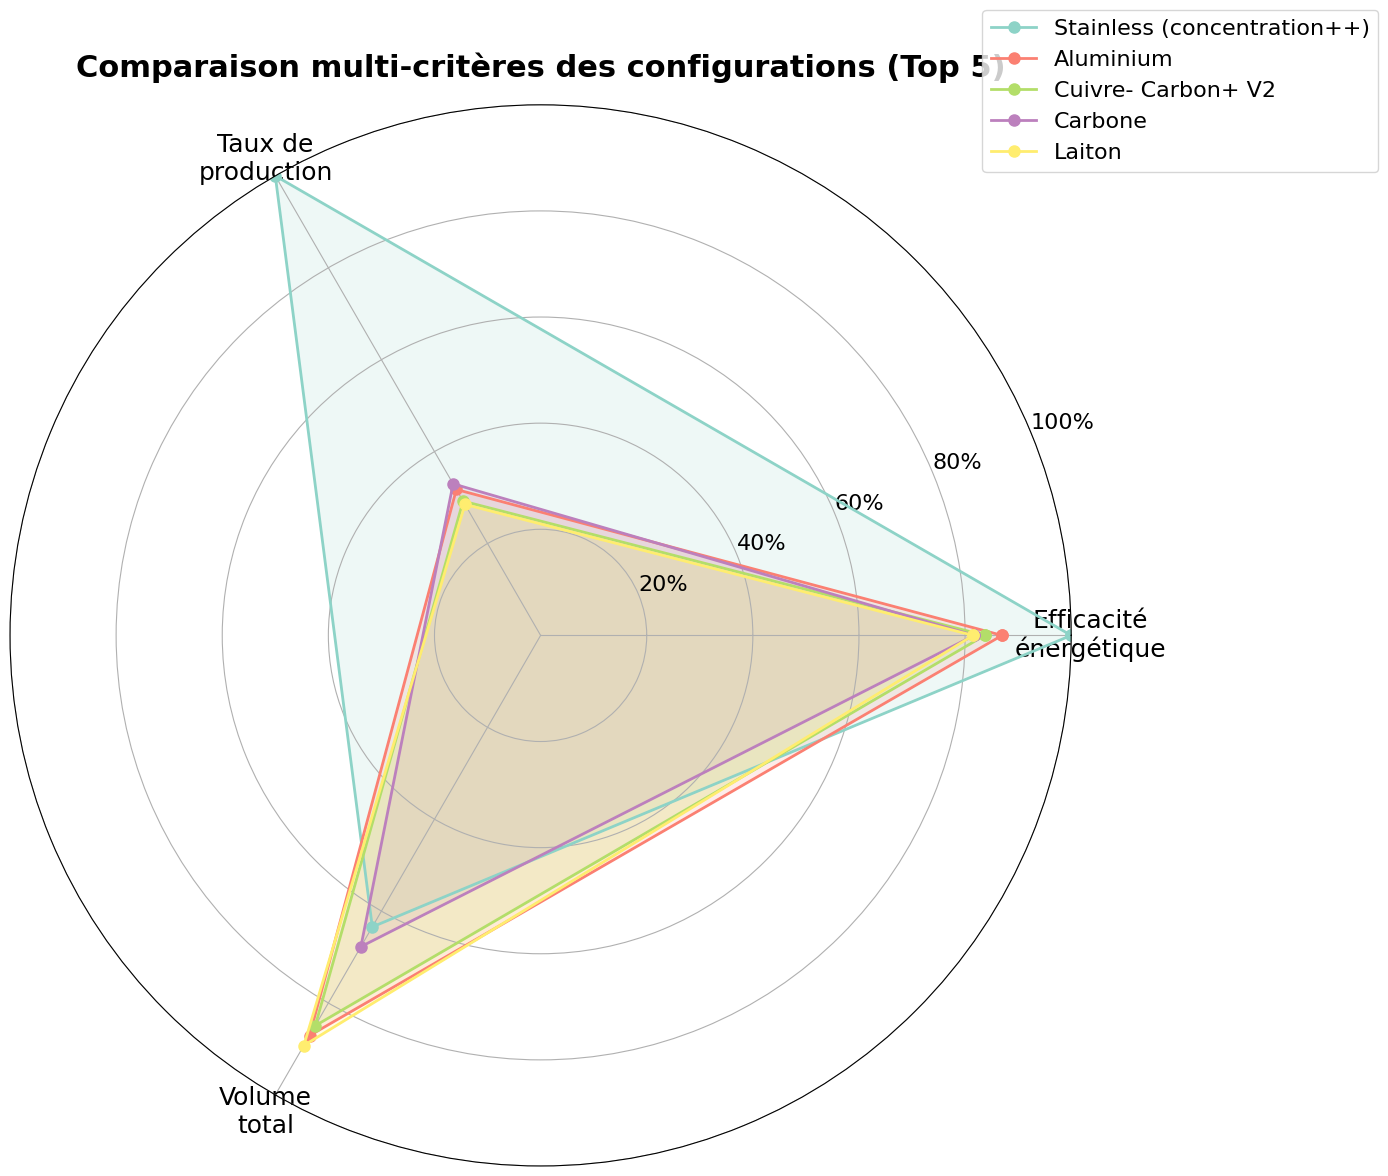

In [9]:
# Graphique radar pour comparaison multi-critères
import numpy as np

# Normaliser les métriques pour le graphique radar (0-1)
df_radar = df_valid.copy()

# Sélectionner les critères à comparer
metriques = ['Efficacité H₂ [ml/Wh]', 'Taux H₂ [ml/s]', 'Volume H₂ [ml]']

# Normalisation min-max
for metric in metriques:
    min_val = df_radar[metric].min()
    max_val = df_radar[metric].max()
    df_radar[f'{metric}_norm'] = (df_radar[metric] - min_val) / (max_val - min_val)

# Créer le graphique radar pour les 5 meilleures configurations
top_configs = df_valid.nlargest(5, 'Efficacité H₂ [ml/Wh]')

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='polar')

# Définir les angles pour chaque axe
angles = np.linspace(0, 2 * np.pi, len(metriques), endpoint=False).tolist()
angles += angles[:1]  # Fermer le polygone

# Couleurs pour chaque configuration
colors = plt.cm.Set3(np.linspace(0, 1, len(top_configs)))

# Tracer chaque configuration
for i, (idx, row) in enumerate(top_configs.iterrows()):
    values = [df_radar.loc[idx, f'{m}_norm'] for m in metriques]
    values += values[:1]  # Fermer le polygone
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Électrodes'], 
            color=colors[i], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors[i])

# Configurer les axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Efficacité\nénergétique', 'Taux de\nproduction', 'Volume\ntotal'], 
                   fontsize=18)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=16)
ax.grid(True)

plt.title('Comparaison multi-critères des configurations (Top 5)', 
          size=22, weight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=16)

plt.tight_layout()
plt.show()

## Export des données traitées

Sauvegardons les données analysées dans un fichier CSV pour référence future.

In [10]:
# Sauvegarder le DataFrame complet dans un fichier CSV
output_filename = 'Données_Électrolyse_Analysées.csv'
df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"✓ Données sauvegardées dans: {output_filename}")
print(f"✓ Nombre de configurations: {len(df)}")
print(f"✓ Nombre de métriques calculées: {len(df.columns)}")

# Afficher un résumé final
print("\n" + "="*100)
print("RÉSUMÉ DE L'ANALYSE")
print("="*100)
print(f"\nConfigurations testées: {len(electrodes)}")
print(f"Configurations valides (données complètes): {len(df_valid)}")
print(f"\nVolume total H₂ produit: {df['Volume H₂ [ml]'].sum():.1f} ml")
print(f"Volume total O₂ produit: {df['Volume O₂ [ml]'].sum():.1f} ml")
print(f"\nMeilleure efficacité énergétique: {df_valid['Efficacité H₂ [ml/Wh]'].max():.3f} ml H₂/Wh")
print(f"  Configuration: {df_valid.loc[df_valid['Efficacité H₂ [ml/Wh]'].idxmax(), 'Électrodes']}")
print(f"\nMeilleur taux de production: {df_valid['Taux H₂ [ml/s]'].max():.5f} ml H₂/s")
print(f"  Configuration: {df_valid.loc[df_valid['Taux H₂ [ml/s]'].idxmax(), 'Électrodes']}")
print("="*100)

✓ Données sauvegardées dans: Données_Électrolyse_Analysées.csv
✓ Nombre de configurations: 9
✓ Nombre de métriques calculées: 21

RÉSUMÉ DE L'ANALYSE

Configurations testées: 9
Configurations valides (données complètes): 8

Volume total H₂ produit: 315.5 ml
Volume total O₂ produit: 131.5 ml

Meilleure efficacité énergétique: 59.504 ml H₂/Wh
  Configuration: Stainless (concentration++)

Meilleur taux de production: 0.24793 ml H₂/s
  Configuration: Stainless (concentration++)
